In [1]:
import pandas as pd
fish_with_population=pd.read_csv("data_with_fish_health_and_population.csv")
fish_with_no_population=pd.read_csv("data_with_fish_health_no_population.csv")
print("fish_with_population")
print(fish_with_population.info())
print("\n")
print("fish_with_no_population")
print(fish_with_no_population.info())

fish_with_population
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764315 entries, 0 to 764314
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               764315 non-null  object 
 1   entry_id                764315 non-null  float64
 2   temperature             764315 non-null  float64
 3   turbidity               764315 non-null  float64
 4   dissolved_oxygen        764315 non-null  float64
 5   ph                      764315 non-null  float64
 6   ammonia                 764225 non-null  float64
 7   nitrate                 764315 non-null  float64
 8   population              612530 non-null  float64
 9   fish_length             764314 non-null  float64
 10  fish_weight             764315 non-null  float64
 11  water_safety_score      764315 non-null  float64
 12  safety_category         764315 non-null  object 
 13  source_df               764315 non-null  int64  
 14 

In [7]:
# Handle mixed timestamp formats
def parse_timestamp(ts):
    if pd.isna(ts):
        return pd.NaT
    ts_str = str(ts).strip()
    
    # Handle format: "2021-06-19 00:00:05 CET"
    if 'CET' in ts_str:
        try:
            ts_no_tz = ts_str.replace(' CET', '')
            return pd.to_datetime(ts_no_tz)
        except:
            return pd.NaT
    
    # Handle format: "2021-06-19 00:01:46 UTC"  
    elif 'UTC' in ts_str:
        try:
            ts_no_tz = ts_str.replace(' UTC', '')
            return pd.to_datetime(ts_no_tz)
        except:
            return pd.NaT
    
    # Handle format: "16/01/2022" (DD/MM/YYYY)
    elif '/' in ts_str and len(ts_str.split('/')) == 3:
        try:
            return pd.to_datetime(ts_str, dayfirst=True)
        except:
            return pd.NaT
    
    # Try default parsing for other formats
    else:
        try:
            return pd.to_datetime(ts_str)
        except:
            return pd.NaT

# Apply the parsing function
df=fish_with_population.copy()
df['timestamp'] = df['timestamp'].apply(parse_timestamp)
# Sort by timestamp
df = df.sort_values('timestamp')

# Now extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['date'] = df['timestamp'].dt.date
df['year'] = df['timestamp'].dt.year
fish_with_population=df.copy()

df=fish_with_no_population.copy()
df['timestamp'] = df['timestamp'].apply(parse_timestamp)
# Sort by timestamp
df = df.sort_values('timestamp')

# Now extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['date'] = df['timestamp'].dt.date
df['year'] = df['timestamp'].dt.year
fish_with_no_population=df.copy()

C:\Users\kaout\AppData\Local\Temp\ipykernel_23084\1336291449.py:33: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(ts_str)
C:\Users\kaout\AppData\Local\Temp\ipykernel_23084\1336291449.py:33: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(ts_str)


In [10]:
print("fish_with_population")
print(fish_with_population.info())
print("fish_with_no_population")
print(fish_with_no_population.info())

fish_with_population
<class 'pandas.core.frame.DataFrame'>
Index: 764315 entries, 531940 to 667293
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               764315 non-null  datetime64[ns]
 1   entry_id                764315 non-null  float64       
 2   temperature             764315 non-null  float64       
 3   turbidity               764315 non-null  float64       
 4   dissolved_oxygen        764315 non-null  float64       
 5   ph                      764315 non-null  float64       
 6   ammonia                 764225 non-null  float64       
 7   nitrate                 764315 non-null  float64       
 8   population              612530 non-null  float64       
 9   fish_length             764314 non-null  float64       
 10  fish_weight             764315 non-null  float64       
 11  water_safety_score      764315 non-null  float64       
 12  safety_ca

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from xgboost import XGBRegressor, XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [16]:
# DEBUGGING VERSION - Identify exactly which columns have issues
def debug_preprocess_fish_data(df, dataset_name):    
    df_clean = df.copy()
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    problematic_cols = []
    
    for col in numerical_cols:        
        # Check for infinite values
        inf_count = np.isinf(df_clean[col]).sum()
        if inf_count > 0:
            problematic_cols.append((col, 'infinite'))
        
        # Check for extreme values
        max_val = df_clean[col].max()
        min_val = df_clean[col].min()
        if max_val > 1e10 or min_val < -1e10:
            problematic_cols.append((col, 'extreme'))
    
    # Simple fix: replace inf with NaN, then fill NaN with median
    for col in numerical_cols:
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    return df_clean

# Use debugging version if needed
df_population = debug_preprocess_fish_data(fish_with_population, "With Population")
df_no_population = debug_preprocess_fish_data(fish_with_no_population, "Without Population")
print(df_population.info())
print("\n")
print(df_no_population.info())

<class 'pandas.core.frame.DataFrame'>
Index: 764315 entries, 531940 to 667293
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   timestamp               764315 non-null  datetime64[ns]
 1   entry_id                764315 non-null  float64       
 2   temperature             764315 non-null  float64       
 3   turbidity               764315 non-null  float64       
 4   dissolved_oxygen        764315 non-null  float64       
 5   ph                      764315 non-null  float64       
 6   ammonia                 764315 non-null  float64       
 7   nitrate                 764315 non-null  float64       
 8   population              764315 non-null  float64       
 9   fish_length             764315 non-null  float64       
 10  fish_weight             764315 non-null  float64       
 11  water_safety_score      764315 non-null  float64       
 12  safety_category         764315

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from xgboost import XGBRegressor, XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

def train_regression_models(X, y, target_name, dataset_name):
    # Basic data validation
    if len(X) == 0 or len(y) == 0:
        return None, None, None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define regression models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        try:
            # Train model
            if name in ['Random Forest', 'XGBoost']:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='r2', n_jobs=-1)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = np.mean(np.abs(y_test - y_pred))
            
            results[name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'CV_R2_mean': cv_scores.mean(),
                'CV_R2_std': cv_scores.std()
            }
            trained_models[name] = model
            
            print(f"R²: {r2:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        except Exception as e:
            results[name] = {'RMSE': 0, 'MAE': 0, 'R2': 0, 'CV_R2_mean': 0, 'CV_R2_std': 0}
    
    if not trained_models:
        return None, None, None
    
    # Compare results
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('R2', ascending=False)
    print(f"\nModel Comparison for {target_name}:")
    print(results_df.round(4))
    
    # Save best model
    best_model_name = results_df.index[0]
    best_model = trained_models[best_model_name]
    
    return best_model, scaler, results_df

def train_classification_models(X, y, target_name, dataset_name):

    # Encode target if categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        class_names = le.classes_
        class_counts = pd.Series(y_encoded).value_counts().sort_index()
        print(f"Class distribution: {dict(zip(class_names, class_counts))}")
        
        # Check for rare classes (less than 2 samples)
        rare_classes = class_counts[class_counts < 2]
        if len(rare_classes) > 0:            
            # Keep only classes with at least 2 samples
            valid_classes = class_counts[class_counts >= 2].index
            mask = np.isin(y_encoded, valid_classes)
            X = X[mask]
            y_encoded = y_encoded[mask]
            print(f"  After filtering: {len(X)} samples, {len(valid_classes)} classes")
    else:
        y_encoded = y
        le = None
        class_names = None
    
    # Check if we have enough data and classes after filtering
    if len(X) == 0:
        return None, None, None, None
    
    if len(np.unique(y_encoded)) < 2:
        return None, None, None, None
    
    # Split data (without stratification if we have rare classes)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        print("  Used stratified split")
    except ValueError:
        print("  Using random split (stratification not possible)")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42
        )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define classification models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, n_jobs=-1)
    }
    
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        try:
            # Train model
            if name in ['Random Forest', 'XGBoost']:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                cv_scores = cross_val_score(model, X_train, y_train, cv=min(3, len(np.unique(y_train))), scoring='accuracy', n_jobs=-1)
            else:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=min(3, len(np.unique(y_train))), scoring='accuracy', n_jobs=-1)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            
            results[name] = {
                'Accuracy': accuracy,
                'CV_Accuracy_mean': cv_scores.mean(),
                'CV_Accuracy_std': cv_scores.std()
            }
            trained_models[name] = model
            
            print(f"Accuracy: {accuracy:.4f}")
            print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            # Show classification report for good models
            if accuracy > 0.85 and le is not None:
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, target_names=[le.classes_[i] for i in np.unique(y_encoded)]))
        
        except Exception as e:
            results[name] = {'Accuracy': 0, 'CV_Accuracy_mean': 0, 'CV_Accuracy_std': 0}
    
    if not trained_models:
        return None, None, None, None
    
    # Compare results
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('Accuracy', ascending=False)
    print(f"\nModel Comparison for {target_name}:")
    print(results_df.round(4))
    
    # Save best model
    best_model_name = results_df.index[0]
    best_model = trained_models[best_model_name]
    
    return best_model, scaler, le, results_df

def train_fish_population_models(df):
    # Prepare features
    exclude_cols = ['fish_health_category', 'safety_category', 'fish_health_score', 
                   'fish_length_score', 'fish_weight_score', 'condition_factor_score', 
                   'population_score', 'water_safety_score']
    
    feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.number, np.int32, np.int64]]
    X = df[feature_cols]
    
    print(f"Features: {len(feature_cols)}")
    print(f"Feature names: {feature_cols}")
    
    models_dict = {}
    
    # Task 1: Predict fish_health_score (Regression)
    y_health_score = df['fish_health_score']
    health_model, health_scaler, health_results = train_regression_models(
        X, y_health_score, 'Fish Health Score', 'With Population'
    )
    if health_model is not None:
        models_dict['health_score'] = (health_model, health_scaler, 'regression')
    y_health_category = df['fish_health_category']
    category_model, category_scaler, category_le, category_results = train_classification_models(  
        X, y_health_category, 'Fish Health Category', 'With Population'
    )
    if category_model is not None:
        models_dict['health_category'] = (category_model, category_scaler, category_le, 'classification')
    else:
        print("Health category classification skipped due to data issues")
    
    # Task 3: Predict population (Regression)
    if 'population' in feature_cols:
        print("\n3. Training Population Regression Model...")
        X_pop = X.drop('population', axis=1) if 'population' in X.columns else X
        y_pop = df['population']
        pop_model, pop_scaler, pop_results = train_regression_models(
            X_pop, y_pop, 'Population', 'With Population'
        )
        if pop_model is not None:
            models_dict['population'] = (pop_model, pop_scaler, 'regression')
    
    return models_dict, feature_cols

def train_fish_no_population_models(df):
    # Prepare features
    exclude_cols = ['fish_health_category', 'safety_category', 'fish_health_score', 
                   'fish_length_score', 'fish_weight_score', 'condition_factor_score', 
                   'water_safety_score']
    
    feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.number, np.int32, np.int64]]
    X = df[feature_cols]
    
    print(f"Features: {len(feature_cols)}")
    print(f"Feature names: {feature_cols}")
    
    models_dict = {}
    
    # Task 1: Predict individual fish health score (Regression)
    y_health_score = df['fish_health_score']
    health_model, health_scaler, health_results = train_regression_models(
        X, y_health_score, 'Individual Fish Health Score', 'No Population'
    )
    if health_model is not None:
        models_dict['health_score'] = (health_model, health_scaler, 'regression')
    
    y_health_category = df['fish_health_category']
    category_model, category_scaler, category_le, category_results = train_classification_models(  
        X, y_health_category, 'Individual Fish Health Category', 'No Population'
    )
    if category_model is not None:
        models_dict['health_category'] = (category_model, category_scaler, category_le, 'classification')
    else:
        print("Health category classification skipped due to data issues")
    
    # Task 3: Predict growth metrics
    if 'fish_weight' in feature_cols and 'fish_length' in feature_cols:        
        # Predict fish weight from other features
        y_weight = df['fish_weight']
        weight_features = [col for col in feature_cols if col != 'fish_weight']
        weight_model, weight_scaler, weight_results = train_regression_models(
            X[weight_features], y_weight, 'Fish Weight', 'No Population'
        )
        if weight_model is not None:
            models_dict['fish_weight'] = (weight_model, weight_scaler, 'regression')
        
        # Predict fish length from other features
        y_length = df['fish_length']
        length_features = [col for col in feature_cols if col != 'fish_length']
        length_model, length_scaler, length_results = train_regression_models(
            X[length_features], y_length, 'Fish Length', 'No Population'
        )
        if length_model is not None:
            models_dict['fish_length'] = (length_model, length_scaler, 'regression')
    
    return models_dict, feature_cols

# Train models for dataset with population
population_models, population_features = train_fish_population_models(df_population)

# Train models for dataset without population
no_population_models, no_population_features = train_fish_no_population_models(df_no_population)

import os
os.makedirs('fish_health_models', exist_ok=True)

# Save population models
if population_models:
    for model_name, model_info in population_models.items():
        if len(model_info) >= 2:  # Ensure we have at least model and scaler
            model, scaler = model_info[0], model_info[1]
            joblib.dump(model, f'fish_health_models/population_{model_name}_model.pkl')
            joblib.dump(scaler, f'fish_health_models/population_{model_name}_scaler.pkl')
            
            # Save label encoder for classification models
            if len(model_info) > 2 and model_info[2] is not None:
                joblib.dump(model_info[2], f'fish_health_models/population_{model_name}_encoder.pkl')
            
            print(f"Saved population {model_name} model")
else:
    print("No population models to save")

# Save no-population models
if no_population_models:
    for model_name, model_info in no_population_models.items():
        if len(model_info) >= 2:  # Ensure we have at least model and scaler
            model, scaler = model_info[0], model_info[1]
            joblib.dump(model, f'fish_health_models/no_population_{model_name}_model.pkl')
            joblib.dump(scaler, f'fish_health_models/no_population_{model_name}_scaler.pkl')
            
            # Save label encoder for classification models
            if len(model_info) > 2 and model_info[2] is not None:
                joblib.dump(model_info[2], f'fish_health_models/no_population_{model_name}_encoder.pkl')
            
            print(f"Saved no-population {model_name} model")
else:
    print("No no-population models to save")

# Save feature information
feature_info = {
    'population_features': population_features,
    'no_population_features': no_population_features
}
joblib.dump(feature_info, 'fish_health_models/feature_info.pkl')

Features: 16
Feature names: ['entry_id', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight', 'source_df', 'condition_factor', 'hour', 'day_of_week', 'month', 'year']

--- Random Forest ---
R²: 1.0000
RMSE: 0.0272
MAE: 0.0003
CV R²: 1.0000 (+/- 0.0001)

--- XGBoost ---
R²: 1.0000
RMSE: 0.0538
MAE: 0.0193
CV R²: 1.0000 (+/- 0.0001)

--- Gradient Boosting ---
R²: 0.9977
RMSE: 0.5560
MAE: 0.3656
CV R²: 0.9976 (+/- 0.0001)

Model Comparison for Fish Health Score:
                     RMSE     MAE      R2  CV_R2_mean  CV_R2_std
Random Forest      0.0272  0.0003  1.0000      1.0000        0.0
XGBoost            0.0538  0.0193  1.0000      1.0000        0.0
Gradient Boosting  0.5560  0.3656  0.9977      0.9976        0.0
Class distribution: {'CRITICAL': 1, 'EXCELLENT': 323963, 'FAIR': 96359, 'GOOD': 343992}
  After filtering: 764314 samples, 3 classes
  Used stratified split

--- Random Forest ---
Accuracy: 1.0000
CV Accuracy:

['fish_health_models/feature_info.pkl']

In [26]:
def hybrid_fish_health_predictor(new_data, has_population=True):
    if has_population and 'population' in new_data.columns:
        # Use population models
        model_type = 'population'
    else:
        # Use no-population models
        model_type = 'no_population'
    
    predictions = {}
    
    # Load appropriate models
    try:
        # Health score prediction
        health_model = joblib.load(f'fish_health_models/{model_type}_health_score_model.pkl')
        health_scaler = joblib.load(f'fish_health_models/{model_type}_health_score_scaler.pkl')
        
        # Prepare features
        feature_info = joblib.load('fish_health_models/feature_info.pkl')
        features = feature_info[f'{model_type}_features']
        
        # Ensure we have all required features
        available_features = [f for f in features if f in new_data.columns]
        X_new = new_data[available_features]
        
        # Scale and predict
        X_scaled = health_scaler.transform(X_new)
        health_score_pred = health_model.predict(X_scaled)
        predictions['health_score'] = health_score_pred
        
        # Health category prediction
        category_model = joblib.load(f'fish_health_models/{model_type}_health_category_model.pkl')
        category_scaler = joblib.load(f'fish_health_models/{model_type}_health_category_scaler.pkl')
        category_encoder = joblib.load(f'fish_health_models/{model_type}_health_category_encoder.pkl')
        
        X_cat_scaled = category_scaler.transform(X_new)
        category_pred_encoded = category_model.predict(X_cat_scaled)
        category_pred = category_encoder.inverse_transform(category_pred_encoded)
        predictions['health_category'] = category_pred
                
    except Exception as e:
        print(f"Error in prediction: {e}")
    
    return predictions


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

feature_info = joblib.load('fish_health_models/feature_info.pkl')

def analyze_regression_overfitting(model_name, dataset_type):
    try:
        # Load model and scaler
        model = joblib.load(f'fish_health_models/{dataset_type}_{model_name}_model.pkl')
        scaler = joblib.load(f'fish_health_models/{dataset_type}_{model_name}_scaler.pkl')
        
        # Get appropriate dataset
        if dataset_type == 'population':
            X = df_population[feature_info['population_features']]
            y = df_population['fish_health_score'] if model_name == 'health_score' else df_population[model_name]
        else:
            X = df_no_population[feature_info['no_population_features']]
            if model_name == 'health_score':
                y = df_no_population['fish_health_score']
            elif model_name in ['fish_weight', 'fish_length']:
                y = df_no_population[model_name]
            else:
                y = df_no_population[model_name]
        
        # Split data
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # 1. Learning Curve
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=3, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='r2', random_state=42
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training Score", linewidth=2)
        plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-Val Score", linewidth=2)
        plt.xlabel("Training Examples")
        plt.ylabel("R² Score")
        plt.title(f"Learning Curve: {model_name}\n({dataset_type})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        performance_gap = train_r2 - test_r2
        
        plt.subplot(1, 2, 2)
        metrics = ['Train R²', 'Test R²', 'Train RMSE', 'Test RMSE']
        values = [train_r2, test_r2, train_rmse, test_rmse]
        colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightsalmon']
        
        bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)
        plt.ylabel('Score')
        plt.title(f'Performance Comparison\nGap: {performance_gap:.4f}')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²:  {test_r2:.4f}")
        print(f"R² Gap:   {performance_gap:.4f}")
        print(f"Train RMSE: {train_rmse:.4f}")
        print(f"Test RMSE:  {test_rmse:.4f}")
            
        return performance_gap
        
    except Exception as e:
        print(f"Error analyzing {model_name}: {e}")
        return None

In [28]:
def analyze_classification_overfitting(dataset_type):
    try:
        # Load model, scaler, and encoder
        model = joblib.load(f'fish_health_models/{dataset_type}_health_category_model.pkl')
        scaler = joblib.load(f'fish_health_models/{dataset_type}_health_category_scaler.pkl')
        encoder = joblib.load(f'fish_health_models/{dataset_type}_health_category_encoder.pkl')
        
        # Get appropriate dataset
        if dataset_type == 'population':
            X = df_population[feature_info['population_features']]
            y = df_population['fish_health_category']
        else:
            X = df_no_population[feature_info['no_population_features']]
            y = df_no_population['fish_health_category']
        
        # Encode target
        y_encoded = encoder.transform(y)
        
        # Split data
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Scale features
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=3, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy', random_state=42
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training Score", linewidth=2)
        plt.plot(train_sizes, test_scores_mean, 'o-', color="blue", label="Cross-Val Score", linewidth=2)
        plt.xlabel("Training Examples")
        plt.ylabel("Accuracy Score")
        plt.title(f"Learning Curve: Health Category\n({dataset_type})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        performance_gap = train_accuracy - test_accuracy
        
        plt.subplot(1, 2, 2)
        metrics = ['Train Accuracy', 'Test Accuracy']
        values = [train_accuracy, test_accuracy]
        colors = ['lightgreen', 'lightblue']
        
        bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)
        plt.ylabel('Accuracy Score')
        plt.title(f'Performance Comparison\nGap: {performance_gap:.4f}')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy:  {test_accuracy:.4f}")
        print(f"Accuracy Gap:   {performance_gap:.4f}")
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.title(f'Confusion Matrix - {dataset_type}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Class-wise performance
        print("\n4. CLASS-WISE PERFORMANCE:")
        class_report = classification_report(y_test, y_test_pred, target_names=encoder.classes_, output_dict=True)
        for class_name in encoder.classes_:
            precision = class_report[class_name]['precision']
            recall = class_report[class_name]['recall']
            f1 = class_report[class_name]['f1-score']
            print(f"  {class_name:10}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
            
        return performance_gap
        
    except Exception as e:
        print(f" Error analyzing classification: {e}")
        return None

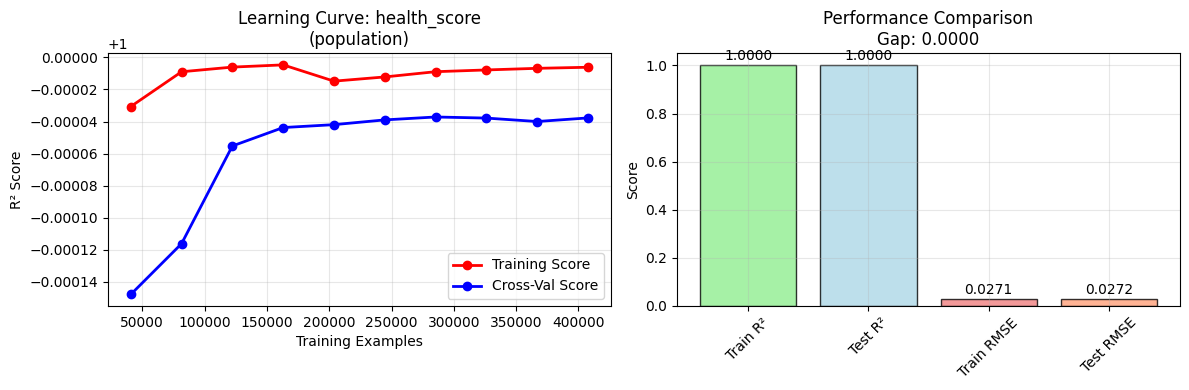

Train R²: 1.0000
Test R²:  1.0000
R² Gap:   0.0000
Train RMSE: 0.0271
Test RMSE:  0.0272


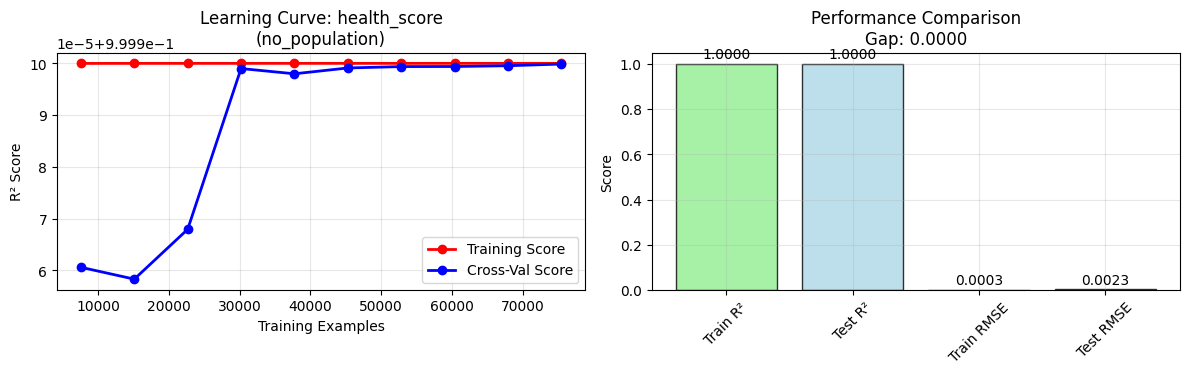

Train R²: 1.0000
Test R²:  1.0000
R² Gap:   0.0000
Train RMSE: 0.0003
Test RMSE:  0.0023
 Error analyzing classification: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


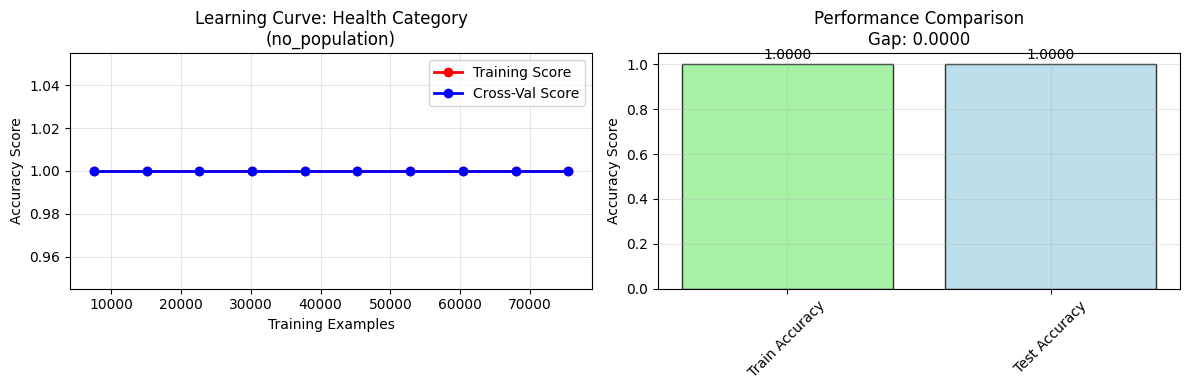

Train Accuracy: 1.0000
Test Accuracy:  1.0000
Accuracy Gap:   0.0000


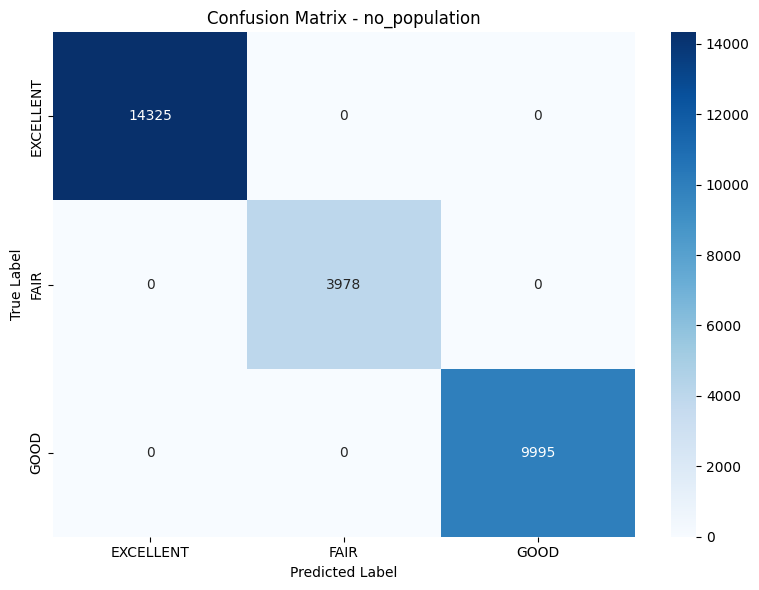


4. CLASS-WISE PERFORMANCE:
  EXCELLENT : Precision=1.000, Recall=1.000, F1=1.000
  FAIR      : Precision=1.000, Recall=1.000, F1=1.000
  GOOD      : Precision=1.000, Recall=1.000, F1=1.000


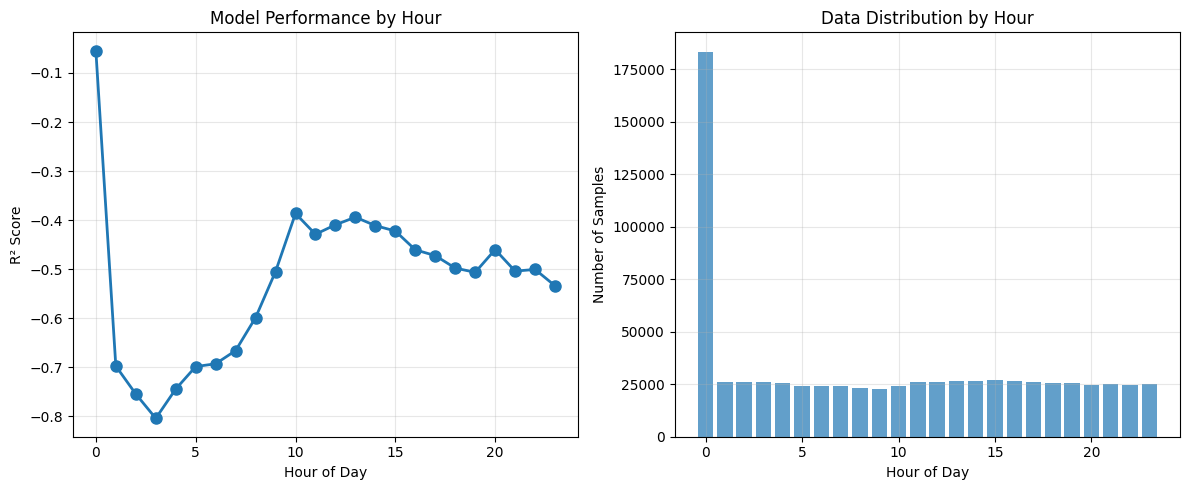

Hourly Performance Summary:
    hour      r2     rmse  samples
0      0 -0.0546  10.4089   183488
1      1 -0.6974  14.1544    25993
2      2 -0.7543  14.3157    26290
3      3 -0.8040  14.3622    25869
4      4 -0.7443  14.1903    25364
5      5 -0.6985  14.0118    24171
6      6 -0.6927  13.9816    24139
7      7 -0.6659  13.9829    24177
8      8 -0.5987  13.7400    23409
9      9 -0.5048  13.4437    22941
10    10 -0.3864  13.1849    24025
11    11 -0.4288  13.4937    25872
12    12 -0.4095  13.3508    25904
13    13 -0.3939  13.2129    26448
14    14 -0.4111  13.3091    26550
15    15 -0.4221  13.4435    26909
16    16 -0.4604  13.6767    26487
17    17 -0.4723  13.7358    25845
18    18 -0.4977  13.8303    25697
19    19 -0.5063  13.7931    25471
20    20 -0.4600  13.5595    24636
21    21 -0.5039  13.7770    24899
22    22 -0.5005  13.7205    24506
23    23 -0.5338  13.8723    25225


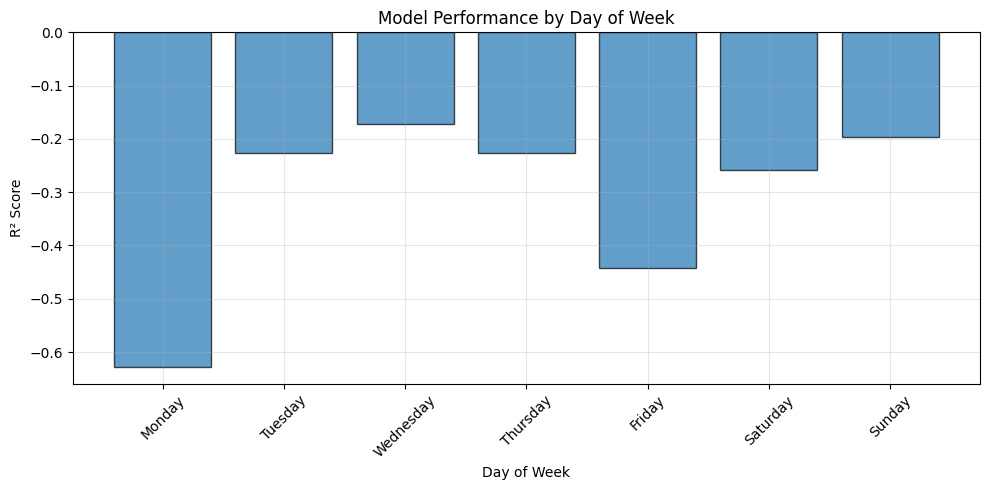

Daily Performance Summary:
         day      r2  samples
0     Monday -0.6283    85879
1    Tuesday -0.2267   114933
2  Wednesday -0.1728   115229
3   Thursday -0.2259   106747
4     Friday -0.4424    99616
5   Saturday -0.2592   119522
6     Sunday -0.1971   122389


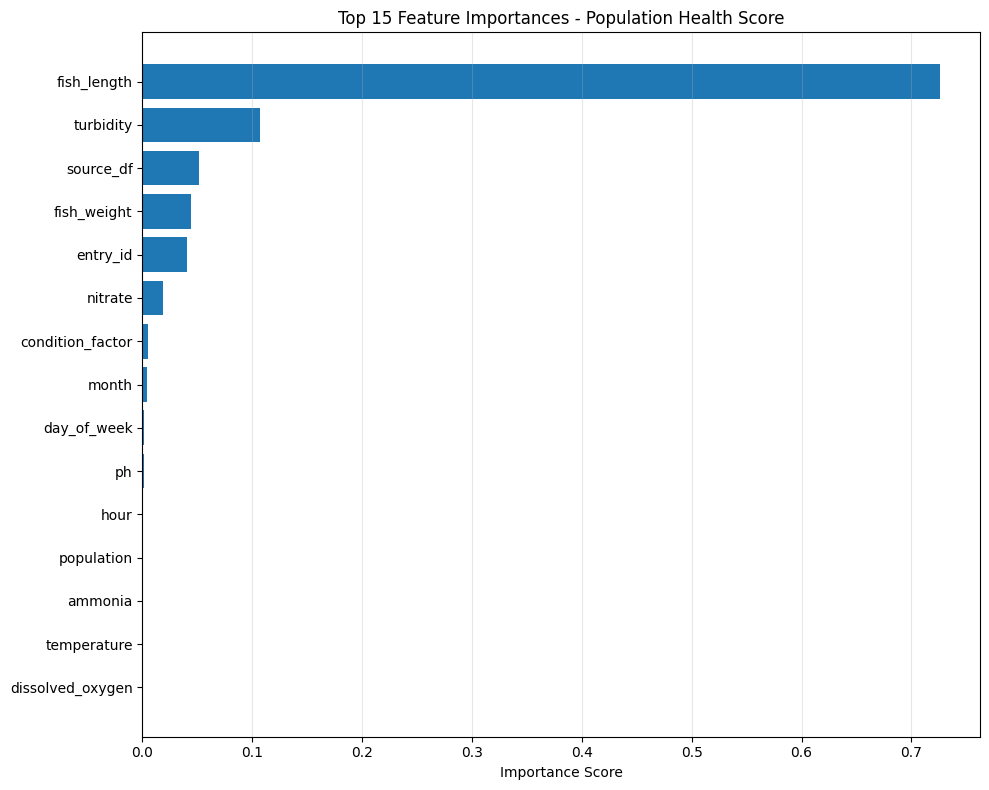

Top 10 Most Important Features:
             feature  importance
8        fish_length      0.7261
2          turbidity      0.1068
10         source_df      0.0511
9        fish_weight      0.0445
0           entry_id      0.0404
6            nitrate      0.0184
11  condition_factor      0.0053
14             month      0.0043
13       day_of_week      0.0017
4                 ph      0.0011


In [29]:
def analyze_temporal_performance():
    # Analyze by hour of day
    if 'hour' in df_population.columns:        
        # Use population dataset as example
        model = joblib.load('fish_health_models/population_health_score_model.pkl')
        scaler = joblib.load('fish_health_models/population_health_score_scaler.pkl')
        
        hours = sorted(df_population['hour'].unique())
        hour_performance = []
        
        for hour in hours:
            hour_data = df_population[df_population['hour'] == hour]
            if len(hour_data) > 10:  # Only analyze hours with sufficient data
                X_hour = hour_data[feature_info['population_features']]
                y_hour = hour_data['fish_health_score']
                
                # Make predictions
                X_scaled = scaler.transform(X_hour)
                y_pred = model.predict(X_scaled)
                
                # Calculate performance
                r2 = r2_score(y_hour, y_pred)
                rmse = np.sqrt(mean_squared_error(y_hour, y_pred))
                hour_performance.append({'hour': hour, 'r2': r2, 'rmse': rmse, 'samples': len(hour_data)})
        
        # Plot hourly performance
        hour_df = pd.DataFrame(hour_performance)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(hour_df['hour'], hour_df['r2'], 'o-', linewidth=2, markersize=8)
        plt.xlabel('Hour of Day')
        plt.ylabel('R² Score')
        plt.title('Model Performance by Hour')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.bar(hour_df['hour'], hour_df['samples'], alpha=0.7)
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Samples')
        plt.title('Data Distribution by Hour')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Hourly Performance Summary:")
        print(hour_df.round(4))
    
    # Analyze by day of week
    if 'day_of_week' in df_population.columns:
        
        days = sorted(df_population['day_of_week'].unique())
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_performance = []
        
        for day in days:
            day_data = df_population[df_population['day_of_week'] == day]
            if len(day_data) > 10:
                X_day = day_data[feature_info['population_features']]
                y_day = day_data['fish_health_score']
                
                X_scaled = scaler.transform(X_day)
                y_pred = model.predict(X_scaled)
                
                r2 = r2_score(y_day, y_pred)
                day_performance.append({'day': day_names[day], 'r2': r2, 'samples': len(day_data)})
        
        day_df = pd.DataFrame(day_performance)
        
        plt.figure(figsize=(10, 5))
        plt.bar(day_df['day'], day_df['r2'], alpha=0.7, edgecolor='black')
        plt.xlabel('Day of Week')
        plt.ylabel('R² Score')
        plt.title('Model Performance by Day of Week')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("Daily Performance Summary:")
        print(day_df.round(4))

def analyze_feature_importance():

    try:
        model = joblib.load('fish_health_models/population_health_score_model.pkl')
        features = feature_info['population_features']
        
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 8))
            plt.barh(importance_df['feature'][:15], importance_df['importance'][:15])
            plt.xlabel('Importance Score')
            plt.title('Top 15 Feature Importances - Population Health Score')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()
            
            print("Top 10 Most Important Features:")
            print(importance_df.head(10).round(4))
    except Exception as e:
        print(f"Could not analyze feature importance: {e}")

regression_gaps = {}

# Population models
if 'population_health_score_model.pkl' in os.listdir('fish_health_models'):
    gap = analyze_regression_overfitting('health_score', 'population')
    if gap is not None:
        regression_gaps['population_health'] = gap

if 'population_fish_weight_model.pkl' in os.listdir('fish_health_models'):
    gap = analyze_regression_overfitting('fish_weight', 'population')
    if gap is not None:
        regression_gaps['population_weight'] = gap

# No-population models  
if 'no_population_health_score_model.pkl' in os.listdir('fish_health_models'):
    gap = analyze_regression_overfitting('health_score', 'no_population')
    if gap is not None:
        regression_gaps['no_population_health'] = gap

# Analyze classification models
classification_gaps = {}

if 'population_health_category_model.pkl' in os.listdir('fish_health_models'):
    gap = analyze_classification_overfitting('population')
    if gap is not None:
        classification_gaps['population'] = gap

if 'no_population_health_category_model.pkl' in os.listdir('fish_health_models'):
    gap = analyze_classification_overfitting('no_population')
    if gap is not None:
        classification_gaps['no_population'] = gap

# Temporal analysis
analyze_temporal_performance()

# Feature importance
analyze_feature_importance()